# Labeling

For each ticker, we want to label the best buy/sell/hold actions (this is the classification label we will train on).

The process goes like this:

- iterate over prices for the ticker (over time)
- e.g. prices: 
- for the first record, we will buy 1 share at that price (this becomes our balance)
- for every following record:
    - if the current price is more than the previous price
        - action = "sell"
        - if previous action is "sell", set previous row action to "hold"
    - if the current price is less than the previous price
        - action = "buy"
        - if previous action is "buy", set previous row action to "hold"
    - keep track of cost basis and profit/loss based on current liquid and realized values

This will iterate like so over the following price list:

- prices = [20, 21, 22, 18, 17, 16, 17]
- actions = 
- buy
- buy, sell
- buy, hold, sell
- buy, hold, sell, buy
- buy, hold, sell, hold, buy
- buy, hold, sell, hold, hold, buy
- buy, hold, sell, hold, hold, buy, sell (final action list)
- $3 profit

In [53]:
import pandas as pd
import os
import matplotlib.pylab as plt

In [54]:
df = pd.read_csv('signals.csv',index_col=None, header=None)
df.columns = ["ticker","price","change","time","meta_signal","meta_previous",
                "4h","1d","1w","1m",
                "4hp","1dp","1wp","1mp",
                "4h_rsi","4h_stochrsi","4h_stoch","4h_ult","4h_macd","4h_hull",
                "1d_rsi","1d_stochrsi","1d_stoch","1d_ult","1d_macd","1d_hull",
                "1w_rsi","1w_stochrsi","1w_stoch","1w_ult","1w_macd","1w_hull",
                "1m_rsi","1m_stochrsi","1m_stoch","1m_ult","1m_macd","1m_hull"
                ,"market","name","meta_move"
                ]
df.head(5)

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1w_hull,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move
0,NASDAQ-AAPL,215.05,0.0000,1534986919851,1,2,1,1,1,1,...,88.93,62.55,1.0,-1,-1,-1,1.0,NASDAQ,AAPL,-1
1,NASDAQ-AAPL,215.97,0.0043,1535031826650,1,2,1,1,1,1,...,89.25,62.95,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
2,NASDAQ-AAPL,216.11,0.0006,1535035652301,1,2,1,1,1,1,...,89.33,63.06,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
3,NASDAQ-AAPL,215.37,-0.0034,1535039080621,1,2,1,1,1,1,...,89.01,62.66,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1
4,NASDAQ-AAPL,216.27,0.0042,1535042375489,1,2,1,1,1,1,...,89.39,63.13,1.0,1,-1,-1,1.0,NASDAQ,AAPL,-1


In [76]:
ticker = df[df.name.astype(str).str.match("BTG")]
ticker

,ticker,price,change,time,meta_signal,meta_previous,4h,1d,1w,1m,...,1w_hull,1m_rsi,1m_stochrsi,1m_stoch,1m_ult,1m_macd,1m_hull,market,name,meta_move
323,AMEX-BTG,2.310,0.0000,1534976694686,-1,0,-1,-1,-1,-1,...,24.02,45.06,-1.0,-1,1,1,-1.0,AMEX,BTG,-1
324,AMEX-BTG,2.240,-0.0303,1535032150741,-1,0,-1,-1,-1,-1,...,22.22,43.23,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1
325,AMEX-BTG,2.235,-0.0022,1535036020573,-1,0,-1,-1,-1,-1,...,21.94,42.94,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1
326,AMEX-BTG,2.210,-0.0112,1535039443967,-1,0,-1,-1,-1,-1,...,21.24,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1
327,AMEX-BTG,2.215,0.0023,1535042714300,-1,0,-1,-1,-1,-1,...,21.24,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,-1
328,AMEX-BTG,2.230,0.0068,1535045953553,-1,-1,-2,-1,-1,-1,...,21.80,42.80,-1.0,-1,-1,-1,-1.0,AMEX,BTG,0
329,AMEX-BTG,2.220,-0.0045,1535049188553,-1,-1,-2,-1,-1,-1,...,21.52,42.52,-1.0,-1,-1,-1,-1.0,AMEX,BTG,0
330,AMEX-BTG,2.205,-0.0068,1535052426363,-1,-1,-2,-1,-1,-1,...,21.24,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,0
331,AMEX-BTG,2.210,0.0023,1535055625766,-1,-1,-2,-1,-1,-1,...,21.24,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,0
332,AMEX-BTG,2.210,0.0000,1535058840180,-1,-1,-2,-1,-1,-1,...,21.24,42.24,-1.0,-1,-1,-1,-1.0,AMEX,BTG,0


<IPython.core.display.Javascript object>


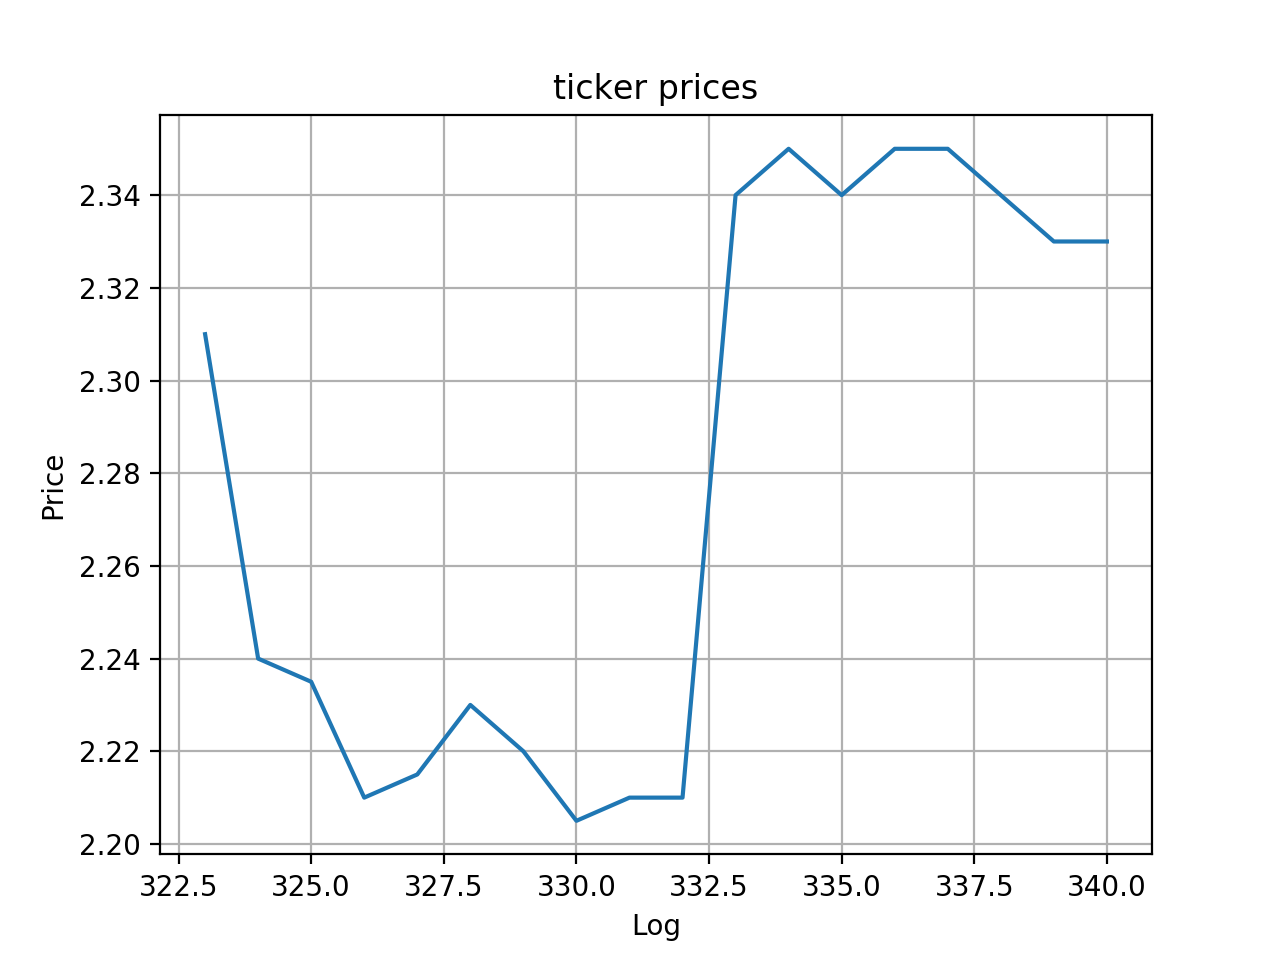

In [78]:
%matplotlib notebook

plt.figure(1)
plt.title('ticker prices')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(ticker.price)
plt.grid(True)
plt.show()

In [177]:
def label_actions(df_ticker, ticker, debug=False):
    df_ticker['action'] = 'hold'
    holding=0
    cost=0
    liquid=0
    profit=0
    buys=0
    sells=0
    last_row_i = 0
    first_row_i = 0
    for i, row in df_ticker.iterrows():
      if last_row_i==0:
        # buy one
        buys += 1
        holding = 1
        cost = row.price
        df_ticker.set_value(i,'action','buy')
        if debug:
            print('buy', holding, cost, profit)
        first_row_i = i
      else:
        last_row = df_ticker.loc[last_row_i]
        if row.price > cost:
            df_ticker.set_value(i,'action','sell')
            if last_row.action == "sell":
                df_ticker.set_value(last_row_i,'action','hold')
            else:
                holding -= 1
                sells += 1
                profit += row.price - cost
                if holding==0:
                    cost = 0
                if debug:
                    print('sell', 1, row.price, holding, "{0:.4f}".format(cost), "{0:.4f}".format(profit))
        elif row.price < last_row.price:
            df_ticker.set_value(i,'action','buy')
            if (last_row_i!=first_row_i) & (last_row.action == "buy"):
                df_ticker.set_value(last_row_i,'action','hold')
            else:
#                 print('lower price', last_row_i, first_row_i, last_row.action, holding)
                if holding==0:
                    print('holding zero', row.price)
                    cost = row.price
                else:
                    cost = ((cost/holding) + row.price) / (holding+1)
                holding += 1
                buys += 1
                if debug:
                    print('buy', holding, "{0:.4f}".format(cost), "{0:.4f}".format(profit))
      last_row_i = i
      liquid = (row.price*holding) - (cost*holding) + profit

    print(ticker+'\t', "holding:", holding, "\tcost:", "{0:.2f}".format(cost), "\trealized:", "{0:.2f}".format(profit), "\tliquid:","{0:.2f}".format(liquid), "\tbuys:", buys, "\tsells:",sells)
    return df_ticker

In [178]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [179]:
ticker_groups = df.groupby('ticker')
# ticker_groups.get_group('NASDAQ-AAPL')
for ticker, group in ticker_groups:
    df_ticker = label_actions(group, ticker)
    
# aapl = df[df.name.astype(str).str.match("AAPL")]
# aapl
# df_ticker = ticker_groups.get_group('AMEX-BTG')
# df_ticker
# df_ticker = label_actions(df_ticker)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AMEX-BTG	 holding: 2 	cost: 1.12 	realized: 1.09 	liquid: 3.51 	buys: 3 	sells: 1
AMEX-COPX	 holding: 2 	cost: 10.62 	realized: 10.57 	liquid: 32.44 	buys: 3 	sells: 1
AMEX-DGRO	 holding: 0 	cost: 0.00 	realized: 0.03 	liquid: 0.03 	buys: 1 	sells: 1
AMEX-EWA	 holding: 2 	cost: 11.22 	realized: 11.17 	liquid: 33.76 	buys: 3 	sells: 1
AMEX-FXI	 holding: 2 	cost: 21.09 	realized: 20.94 	liquid: 63.96 	buys: 3 	sells: 1
AMEX-GDX	 holding: 2 	cost: 9.31 	realized: 9.13 	liquid: 28.42 	buys: 3 	sells: 1
AMEX-GDXJ	 holding: 2 	cost: 13.70 	realized: 13.41 	liquid: 42.45 	buys: 3 	sells: 1
AMEX-GSAT	 holding: 0 	cost: 0.00 	realized: 0.00 	liquid: 0.00 	buys: 1 	sells: 1
AMEX-GTE	 holding: 2 	cost: 1.63 	realized: 1.62 	liquid: 4.98 	buys: 3 	sells: 1
AMEX-HDV	 holding: 1 	cost: 89.48 	realized: 0.01 	liquid: 0.25 	buys: 2 	sells: 1
AMEX-IAU	 holding: 2 	cost: 5.70 	realized: 5.67 	liquid: 17.38 	buys: 3 	sells: 1
AMEX-IDV	 holding: 2 	cost: 16.35 	realized: 16.27 	liquid: 49.19 	buys: 3 	sel

NYSE-ETN	 holding: 2 	cost: 40.47 	realized: 40.01 	liquid: 122.43 	buys: 4 	sells: 2
NYSE-EXG	 holding: 2 	cost: 4.80 	realized: 4.77 	liquid: 14.31 	buys: 3 	sells: 1
NYSE-EXK	 holding: 2 	cost: 1.10 	realized: 1.08 	liquid: 3.53 	buys: 3 	sells: 1
NYSE-F	 holding: 2 	cost: 4.81 	realized: 4.80 	liquid: 14.53 	buys: 3 	sells: 1
NYSE-FNF	 holding: 2 	cost: 20.16 	realized: 20.13 	liquid: 61.08 	buys: 3 	sells: 1
NYSE-FTV	 holding: 0 	cost: 0.00 	realized: 0.00 	liquid: 0.00 	buys: 1 	sells: 1
NYSE-GE	 holding: 0 	cost: 0.00 	realized: 0.03 	liquid: 0.03 	buys: 1 	sells: 1
NYSE-GG	 holding: 2 	cost: 5.43 	realized: 5.37 	liquid: 16.82 	buys: 3 	sells: 1
NYSE-GGP	 holding: 0 	cost: 0.00 	realized: 0.04 	liquid: 0.04 	buys: 1 	sells: 1
NYSE-GME	 holding: 0 	cost: 0.00 	realized: 0.02 	liquid: 0.02 	buys: 1 	sells: 1
NYSE-HASI	 holding: 0 	cost: 0.00 	realized: 0.00 	liquid: 0.00 	buys: 1 	sells: 1
NYSE-HBM	 holding: 2 	cost: 2.39 	realized: 2.36 	liquid: 7.38 	buys: 3 	sells: 1
NYSE-HCLP

In [ ]:
%matplotlib notebook

plt.fig(2)
plt.title('AAPL signals')
plt.xlabel('Log')
plt.ylabel('Price')
plt.plot(aapl.price)
plt.plot(aapl[aapl.action=="sell"].price, 'ro', label='sell')
plt.plot(aapl[aapl.action=="buy"].price, 'go', label='buy')
plt.grid(True)
plt.show()

In [ ]:
# now do it to all of the tickers

ticker_logs = df.groupby('ticker')
ticker_logs

In [ ]:
ticker_logs.head(1)